# Neuro-Symbolic Image Classifier

**Neuro-symbolic AI** is an exciting and innovative approach that merges the best of neural networks and symbolic reasoning. Here’s why this combination is powerful:

### **Advantages of Neural Networks:**
- **Pattern Recognition**: Neural networks excel at learning from raw, unstructured data such as images or text. They are great at recognizing complex patterns and features in large datasets.
- **Flexibility**: Neural networks can adapt to various types of data and tasks, such as image classification, speech recognition, etc. without needing explicit rules.

### **Advantages of Symbolic Reasoning:**
- **Interpretability**: Unlike neural networks, symbolic reasoning allows us to represent and understand logic and decision-making through human-readable rules.
- **Generalization**: Symbolic systems are good at generalizing knowledge from one context to another, making them robust in tasks requiring structured reasoning.

By combining these strengths, **neuro-symbolic AI** overcomes the weaknesses of each approach on its own—using deep learning for feature extraction and symbolic rules for explainable decision-making.

### **Project Overview:**
In this project, I developed a neuro-symbolic classifier for the CIFAR-10 dataset. The model works in two stages:
1. **Feature Recognition**: A neural network is trained to identify high-level features from the images.
2. **Rule-Based Classification**: The decision tree-derived rules are then applied to classify the images based on the recognized features.

### **Key Benefits of This Approach:**
- **High Performance**: By combining deep learning and symbolic reasoning, the model achieves strong feature recongition and image classification abilities.
- **Explainability**: The rules extracted from the decision tree provide transparency, offering a clear and understandable reasoning process for the model's predictions.
- **Hybrid Strength**: This combination results in a classifier that not only performs well but also provides insights into how decisions are made, improving trust and interpretability compared to traditional neural networks.


## Imports

- **Neural Network**:
  - `torch` and `torchvision`: used for building and training the neural network model.
    - `onnx`: used to save a neural network in an onnx format (optional, since the network can also be saved from PyTorch directly)

- **Data Preprocessing**:
  - `torchvision.transforms`: This is used for transforming the images, such as normalization and data augmentation, to improve the model's performance.
  - `numpy`: Provides array operations for handling numerical data, a must for any AI researcher, used in several steps of the project.

- **Symbolic Reasoning**:
  - `sklearn.tree`: This package is used to implement a decision tree model that extracts rules.
  - `sklearn.metrics`: Used to evaluate the performance of the decision tree classifier and calculate accuracy metrics.

- **Visualization and Saving Results**:
  - `matplotlib.pyplot`: This is used to visualize images and results, making it easier to interpret the model's predictions.
  - `pickle`: This is used for saving the final model.


In [1]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 36.7 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.metrics import accuracy_score
import pickle

## Constants Definitions

- **Training Parameters**:
  - `BATCH_SIZE = 64`: This defines the number of images processed in each batch during training.
  - `EPOCHS = 15`: This sets the number of times the entire training dataset is passed through the model.

- **Classes**:
  - `classes`: This is a list of the 10 classes in the CIFAR-10 dataset, representing various objects like airplanes, automobiles, birds, and more. Each image in the dataset belongs to one of these classes.

- **Feature Mapping for Symbolic Reasoning**:
  - `classes_to_features`: This dictionary maps each class to a set of high-level symbolic features. These features represent human-understandable properties of the objects in each class, like whether an object is mechanical, has wings, or is organic. These features help create an interpretable decision-making process after the neural network extracts the high-level features. Ideally, the dataset would already exist with these features in mind, since a plane might sometimes have its wings in the photo, and sometimes it might just be photo of the cockpit, however, to make the process easier on ourselves we just assume that a plane always has these features and that they are always visible in a photo, even if it is not necessarily always the case. What's more, we assume only one class visible per photo, which is true in the case of the CIFAR-10 dataset but one may imagine situations where this is not how it works, perhaps then having a neurosymbolic model might be even more useful.
    - Examples of classes to features:
      - "airplane" is associated with features such as "is_mechanical", "has_wheels", and "has_wings".
      - "cat" is associated with features like "is_organic" and "is_feline".

- **All Possible Features**:
  - `all_possible_features`: This list contains all unique symbolic features across all classes, extracted from the `classes_to_features` dictionary. It is generated by collecting all feature names and eliminating duplicates, providing a comprehensive set of potential features the decision tree can use to classify images.


In [3]:
BATCH_SIZE = 64
EPOCHS = 15
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

classes_to_features = {
    "airplane" : ("is_mechanical", "has_wheels", "has_wings"),
    "automobile" : ("is_mechanical", "has_wheels"),
    "bird" : ("is_organic", "has_wings"),
    "cat" : ("is_organic", "is_feline"),
    "deer" : ("is_organic", "has_hooves"),
    "dog" : ("is_organic", "is_canine"),
    "frog" : ("is_organic", "is_amphibian"),
    "horse" : ("is_organic", "has_hooves", "is_big"),
    "ship" : ("is_mechanical", "on_water"),
    "truck" : ("is_mechanical", "has_wheels", "is_big")
}

all_possible_features = list(set([item for key in classes_to_features for item in classes_to_features[key]]))
print(all_possible_features)

['has_wings', 'on_water', 'is_big', 'is_canine', 'has_hooves', 'is_mechanical', 'has_wheels', 'is_feline', 'is_organic', 'is_amphibian']


## Data

### Data Loading and Visualization

In this part of the code, we are preparing and visualizing the CIFAR-10 dataset:

- **Data Transformation**:
  - `transform`: We define a series of transformations to apply to the images. First, we convert the images to tensors using `transforms.ToTensor()`, and then normalize them with a mean and standard deviation of (0.5, 0.5, 0.5) for each of the three RGB channels. This helps standardize the data and make the neural network training more efficient.

- **Visualizing Examples**:
  - The `plot_example()` function is used to display a batch of images along with their corresponding class labels. We select and plot 8 random images from both the training and test datasets to give a visual understanding of what the model will be working with.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


print(f"Number of training images: {len(trainset)}")
print(f"Number of test images: {len(testset)}")

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training images: 50000
Number of test images: 10000


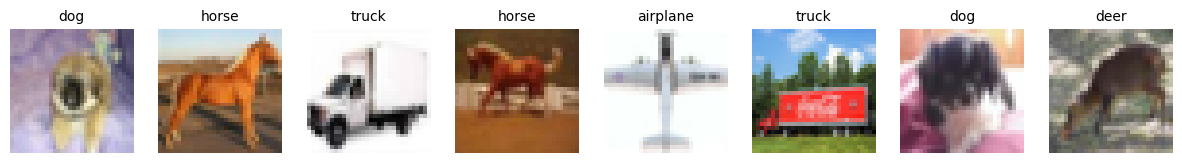

In [5]:
def plot_example(imgs, class_labels, num_images=10):
    """
    Plots a set of images with their corresponding class labels.

    Parameters:
    imgs (Tensor): A batch of images in the shape (N, C, H, W), where N is the batch size,
                   C is the number of channels, H is height, and W is width.
    class_labels (Tensor): A tensor of class indices corresponding to the images.
    num_images (int, optional): The number of images to display. Defaults to 10.

    Returns:
    None: Displays a matplotlib figure with images and their class labels.
    """
    imgs = imgs[:num_images]
    class_labels = class_labels[:num_images]
    imgs = imgs.numpy().transpose((0, 2, 3, 1))
    imgs = imgs * 0.5 + 0.5

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(imgs[i])
        axes[i].axis("off")
        axes[i].set_title(classes[class_labels[i].item()], fontsize=10)

    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
plot_example(images, labels, num_images=8)

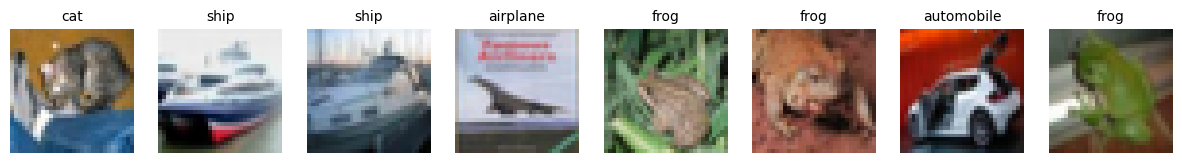

In [6]:
dataiter = iter(testloader)
images, labels = next(dataiter)
plot_example(images, labels, num_images=8)

## Convolutional Neural Network for Feature Detection

This section is centered around the convolutional neural network for feature detection. We model the problem as a multi-label classification problem. The model is forced to detect the earlier-defined high-level features for each image. First, to accomplish this task, we transform the dataset where for each class we translate it to the features defined in classes_to_features. Then, we can use these one-hot encoded features to train the model. The loss function utilized here is binary cross-entropy often used in the tasks of multi-label classification.

In [7]:
def transform_dataset(dataset, class_names, class_mapping, one_hot_encoded_mapping):
    """
    Transforms a dataset by converting class labels into a one-hot encoded features.

    Parameters:
    dataset (iterable): Dataset containing (image, label) pairs.
    class_names (list): List of class names corresponding to label indices.
    class_mapping (dict): Dictionary mapping class names to multi-label feature sets.
    one_hot_encoded_mapping (list): List of all possible features for one-hot encoding.

    Returns:
    list: Transformed dataset with images and one-hot encoded labels.
    """
    new_dataset = []
    for img, label in dataset:
        full_temp_features = []
        batch_temp_features = []
        transformed_labels = [class_mapping[class_names[idx]] for idx in list(label)]
        for feature_tuple in transformed_labels:
            all_zeros = [0 for i in range(len(one_hot_encoded_mapping))]
            for feature in feature_tuple:
                index = one_hot_encoded_mapping.index(feature)
                all_zeros[index] = 1.0
            batch_temp_features.append(all_zeros.copy())
        full_temp_features.append(batch_temp_features.copy())
        new_dataset.append((img, np.array(full_temp_features.copy(), dtype=np.float32)))
    return new_dataset

feature_train_dataset = transform_dataset(trainloader, classes, classes_to_features, all_possible_features)
feature_test_dataset = transform_dataset(testloader, classes, classes_to_features, all_possible_features)

In [8]:
def one_hot_to_features(one_hot, feature_mapping, decision_boundery=0.5):
    """
    Converts a one-hot encoded label into a list of feature names.

    Parameters:
    one_hot (list): One-hot encoded vector.
    feature_mapping (list): List mapping indices to feature names.
    decision_boundery (float, optional): Threshold above which a value is considered active. Defaults to 0.5.

    Returns:
    list: List of feature names corresponding to the one-hot encoded vector.
    """
    features = []
    for i in range(len(one_hot)):
        if one_hot[i] > decision_boundery:
            features.append(feature_mapping[i])
    return features

one_hot = [1.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0, 0.6]
print(all_possible_features)
one_hot_to_features(one_hot, all_possible_features)

['has_wings', 'on_water', 'is_big', 'is_canine', 'has_hooves', 'is_mechanical', 'has_wheels', 'is_feline', 'is_organic', 'is_amphibian']


['has_wings', 'has_hooves', 'is_mechanical', 'is_amphibian']

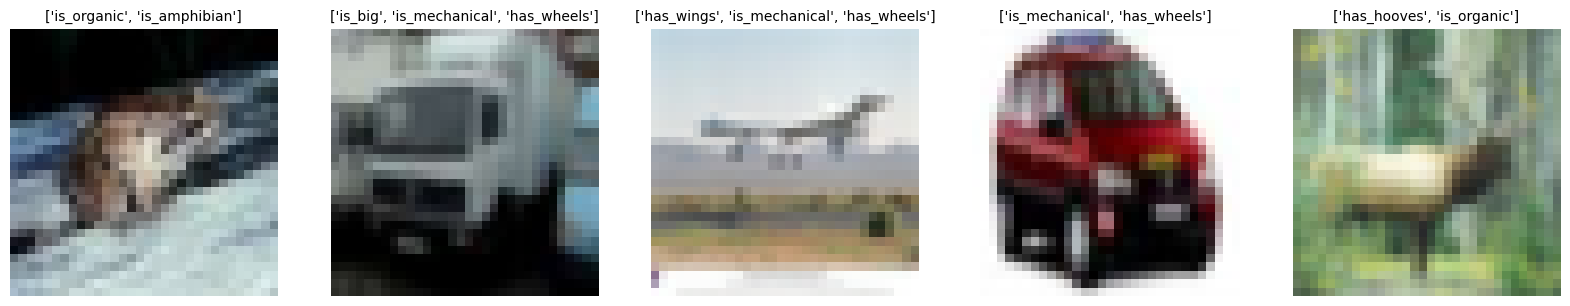

In [9]:
def plot_with_features(imgs, features, feature_mapping, num_images=5):
    """
    Plots images along with their extracted feature labels.

    Parameters:
    imgs (Tensor): A batch of images in (N, C, H, W) format.
    features (ndarray): Corresponding one-hot encoded feature vectors.
    feature_mapping (list): Mapping of one-hot indices to feature labels.
    num_images (int, optional): Number of images to display. Defaults to 5.

    Returns:
    None: Displays a matplotlib figure.
    """
    imgs = imgs[:num_images]
    features = np.squeeze(features)[:num_images]
    imgs = imgs.numpy().transpose((0, 2, 3, 1))
    imgs = imgs * 0.5 + 0.5

    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    for i in range(num_images):
        axes[i].imshow(imgs[i])
        axes[i].axis("off")
        axes[i].set_title(one_hot_to_features(features[i], feature_mapping), fontsize=10)

    plt.show()

dataiter = iter(feature_train_dataset)
images, labels = next(dataiter)
plot_with_features(images, labels, all_possible_features)

In [10]:
class MultiLabelCNN(nn.Module):
    """
    A convolutional neural network for multi-label classification.

    Attributes:
    conv1, conv2, conv3 (nn.Conv2d): Convolutional layers.
    bn1, bn2, bn3 (nn.BatchNorm2d): Batch normalization layers.
    pool (nn.MaxPool2d): Max pooling layer.
    fc1, fc2, fc3 (nn.Linear): Fully connected layers.
    """
    def __init__(self, num_classes=10):
        """
        Initializes the MultiLabelCNN model.

        Parameters:
        num_classes (int, optional): Number of output classes. Defaults to 10.
        """
        super(MultiLabelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        expected_size = self.get_expected_size()
        self.fc1 = nn.Linear(expected_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def get_expected_size(self):
        """
        Computes the output size after convolution and pooling layers.

        Returns:
        int: Flattened feature size before passing into fully connected layers.
        """
        device = next(self.parameters()).device
        random_input = torch.rand((1, 3, 32, 32), device=device)

        x = self.pool(F.relu(self.bn1(self.conv1(random_input))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        """
        Defines the forward pass of the CNN.

        Parameters:
        x (Tensor): Input tensor of shape (batch_size, 3, height, width).

        Returns:
        Tensor: Output logits for each class.
        """
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = MultiLabelCNN(num_classes=10)
print(model)

MultiLabelCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [11]:
dataiter = iter(feature_train_dataset)
images, labels = next(dataiter)
output = model(images.clone().detach().float())
print(output.shape)
print(output[0])

torch.Size([64, 10])
tensor([ 0.1029, -0.0187,  0.0947,  0.2502, -0.0173, -0.0339, -0.0836, -0.1743,
         0.1813, -0.0909], grad_fn=<SelectBackward0>)


In [12]:
def get_multi_label_accuracy(output, expected):
    """
    Computes multi-label accuracy by comparing predicted and expected labels.

    Parameters:
    output (ndarray): Predicted labels (after applying sigmoid activation).
    expected (ndarray): Ground truth labels.

    Returns:
    float: Accuracy as the ratio of correctly predicted labels to total labels.
    """
    output = np.round(output).astype(int)
    expected = np.round(expected).astype(int)
    matching_ones = np.sum((output == 1) & (expected == 1)) + np.sum((output == 0) & (expected == 0))
    total_elements = expected.size
    accuracy = matching_ones / total_elements
    return accuracy

def train_model(model, optimizer, device, criterion, epochs, train_data):
    """
    Trains the given model using multi-label classification.

    Parameters:
    model (torch.nn.Module): The neural network model.
    optimizer (torch.optim.Optimizer): Optimizer for weight updates.
    device (str): "cuda" or "cpu" indicating the computation device.
    criterion (torch.nn.Module): Loss function (e.g., BCEWithLogitsLoss).
    epochs (int): Number of training epochs.
    train_data (iterable): Training dataset containing image-label pairs.

    Returns:
    torch.nn.Module: The trained model.
    """
    model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        accuracy = 0.0
        for images, labels in train_data:
            labels = torch.tensor(np.squeeze(labels), dtype = torch.float32)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            outputs_sigmoid = F.sigmoid(outputs)
            accuracy_step = get_multi_label_accuracy(outputs_sigmoid.to("cpu").clone().detach().float().numpy(), labels.to("cpu").clone().detach().float().numpy())
            accuracy += accuracy_step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_data):.4f}, Accuracy: {accuracy/len(train_data):.4f}")
    return model

def test_model(model, device, criterion, test_data):
    """
    Evaluates the trained model on a test dataset.

    Parameters:
    model (torch.nn.Module): The trained neural network model.
    device (str): "cuda" or "cpu" indicating the computation device.
    criterion (torch.nn.Module): Loss function (e.g., BCEWithLogitsLoss).
    test_data (iterable): Test dataset containing image-label pairs.

    Returns:
    None: Prints test loss and accuracy.
    """
    running_loss = 0.0
    accuracy = 0.0
    model.to(device)
    for images, labels in test_data:
        labels = torch.tensor(np.squeeze(labels), dtype = torch.float32)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        outputs_sigmoid = F.sigmoid(outputs)
        accuracy_step = get_multi_label_accuracy(outputs_sigmoid.to("cpu").clone().detach().float().numpy(), labels.to("cpu").clone().detach().float().numpy())
        accuracy += accuracy_step
        running_loss += loss.item()

    print(f"Test Dataset, Loss: {running_loss/len(test_data):.4f}, Accuracy: {accuracy/len(test_data):.4f}")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Detected Device: {device} \n")
model = train_model(model, optimizer, device, criterion, EPOCHS, feature_train_dataset)
print("\n")
model.eval()
test_model(model, device, criterion, feature_test_dataset)

Detected Device: cuda 

Epoch 1, Loss: 0.2696, Accuracy: 0.8880
Epoch 2, Loss: 0.1931, Accuracy: 0.9218
Epoch 3, Loss: 0.1645, Accuracy: 0.9343
Epoch 4, Loss: 0.1454, Accuracy: 0.9425
Epoch 5, Loss: 0.1300, Accuracy: 0.9491
Epoch 6, Loss: 0.1169, Accuracy: 0.9549
Epoch 7, Loss: 0.1054, Accuracy: 0.9596
Epoch 8, Loss: 0.0955, Accuracy: 0.9636
Epoch 9, Loss: 0.0888, Accuracy: 0.9661
Epoch 10, Loss: 0.0834, Accuracy: 0.9680
Epoch 11, Loss: 0.0813, Accuracy: 0.9687
Epoch 12, Loss: 0.0729, Accuracy: 0.9722
Epoch 13, Loss: 0.0670, Accuracy: 0.9746
Epoch 14, Loss: 0.0621, Accuracy: 0.9764
Epoch 15, Loss: 0.0583, Accuracy: 0.9779


Test Dataset, Loss: 0.1892, Accuracy: 0.9419


In [13]:
torch.save(model.state_dict(), "feature_recognition_cnn.pth")
print("Model saved as feature_recognition_cnn.pth")

Model saved as feature_recognition_cnn.pth


In [14]:
dummy_input = torch.randn(1, 3, 32, 32)

torch.onnx.export(model,
    dummy_input.to(device),
    "feature_recognition_cnn.onnx",
    export_params=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"])

print("Model saved as feature_recognition_cnn.onnx")

Model saved as feature_recognition_cnn.onnx


## Symbolic Classifier

### Rule Extraction and Decision Tree Model

In this part of the code, we extract symbolic rules from the dataset and use a decision tree to classify the images based on these rules. First, we prepare the dataset for the rule extraction. Then, we train the `DecisionTreeClassifier` from `sklearn`. The classifier is trained using the one-hot encoded feature vectors for both the training and test sets. We evaluate the classifier’s accuracy using the `accuracy_score` function.
Once the decision tree is trained, we convert the tree structure into human-readable rules. This recursive function walks through the tree and creates rules based on the splits and leaf nodes. Each rule follows the format: "IF [condition] THEN [class]". These rules describe the decision-making process, making the model’s predictions more interpretable. Lastly, we can visualize the decision tree.


In [15]:
def get_rules_dataset(dataset, class_mapping, class_names, one_hot_encoded_mapping):
    """
    Converts a dataset of images and their corresponding labels into a one-hot encoded features dataset and a list of class names.

    Parameters:
    dataset (iterable): Dataset containing (image, label) pairs.
    class_mapping (dict): A dictionary mapping class names to sets of features.
    class_names (list): List of class names corresponding to label indices.
    one_hot_encoded_mapping (list): List of all possible features for one-hot encoding.

    Returns:
    tuple: A tuple containing:
        - features_one_hot (list): One-hot encoded features for each image.
        - classes_with_names (list): Class names for each image's label.
    """
    features_one_hot = []
    classes_with_names = []
    for img, label in dataset:
        full_temp_features = []
        batch_temp_features = []
        transformed_labels = [class_mapping[class_names[idx]] for idx in list(label)]
        labels_names = [class_names[idx] for idx in list(label)]
        for feature_tuple in transformed_labels:
            all_zeros = [0 for i in range(len(one_hot_encoded_mapping))]
            for feature in feature_tuple:
                index = one_hot_encoded_mapping.index(feature)
                all_zeros[index] = 1.0
            batch_temp_features.append(all_zeros.copy())
        features_one_hot.append(np.array(batch_temp_features.copy(), dtype=np.int8))
        classes_with_names.append(np.array(labels_names, dtype=str))
    return features_one_hot, classes_with_names

def unbatchify_data(X_data, y_data):
    """
    Unbatches the input data (X_data and y_data) from batches into individual samples.

    Parameters:
    X_data (list): List of batched input data (features).
    y_data (list): List of batched labels corresponding to the input data.

    Returns:
    tuple: A tuple containing:
        - X_unbatchified (ndarray): The input data, unbatched into individual examples.
        - y_unbatchified (ndarray): The corresponding labels, unbatched into individual examples.
    """
    X_unbatchified = []
    y_unbatchified = []
    for X_batch in X_data:
        for example in X_batch:
            X_unbatchified.append(example)
    for y_batch in y_data:
        for example in y_batch:
            y_unbatchified.append(example)
    return np.array(X_unbatchified, dtype=np.int8), np.array(y_unbatchified, dtype=str)

rules_train_X, rules_train_y = get_rules_dataset(trainloader, classes_to_features, classes, all_possible_features)
rules_test_X, rules_test_y = get_rules_dataset(testloader, classes_to_features, classes, all_possible_features)
rules_train_X, rules_train_y = unbatchify_data(rules_train_X, rules_train_y)
rules_test_X, rules_test_y = unbatchify_data(rules_test_X, rules_test_y)

In [16]:
clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(rules_train_X, rules_train_y)
y_pred = clf.predict(rules_test_X)

accuracy = accuracy_score(rules_test_y, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 1.00


In [17]:
def tree_to_rules(tree, feature_names):
    """
    Converts a decision tree model into a set of human-readable rules.

    Parameters:
    tree (sklearn.tree.DecisionTreeClassifier): A trained decision tree classifier.
    feature_names (list): A list of feature names corresponding to the input features.

    Returns:
    list: A list of string rules describing the decision tree's splits and leaf nodes.
    """
    tree_ = tree.tree_
    rules = []

    def recurse(node, condition="IF "):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Not a leaf node
            name = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]

            left_condition = f"{condition} (NOT {name}) AND"
            recurse(tree_.children_left[node], left_condition)

            right_condition = f"{condition} ({name}) AND"
            recurse(tree_.children_right[node], right_condition)
        else:  # Leaf node
            class_name = tree_.value[node].argmax()
            rules.append(f"{condition[:-4]} THEN {tree.classes_[class_name]}")

    recurse(0)
    return rules

rules = tree_to_rules(clf, all_possible_features)

for rule in rules:
    print(rule)

IF  (NOT is_organic) AND (NOT has_wings) AND (NOT has_wheels) THEN ship
IF  (NOT is_organic) AND (NOT has_wings) AND (has_wheels) AND (NOT is_big) THEN automobile
IF  (NOT is_organic) AND (NOT has_wings) AND (has_wheels) AND (is_big) THEN truck
IF  (NOT is_organic) AND (has_wings) THEN airplane
IF  (is_organic) AND (NOT has_hooves) AND (NOT has_wings) AND (NOT is_amphibian) AND (NOT is_canine) THEN cat
IF  (is_organic) AND (NOT has_hooves) AND (NOT has_wings) AND (NOT is_amphibian) AND (is_canine) THEN dog
IF  (is_organic) AND (NOT has_hooves) AND (NOT has_wings) AND (is_amphibian) THEN frog
IF  (is_organic) AND (NOT has_hooves) AND (has_wings) THEN bird
IF  (is_organic) AND (has_hooves) AND (NOT is_big) THEN deer
IF  (is_organic) AND (has_hooves) AND (is_big) THEN horse


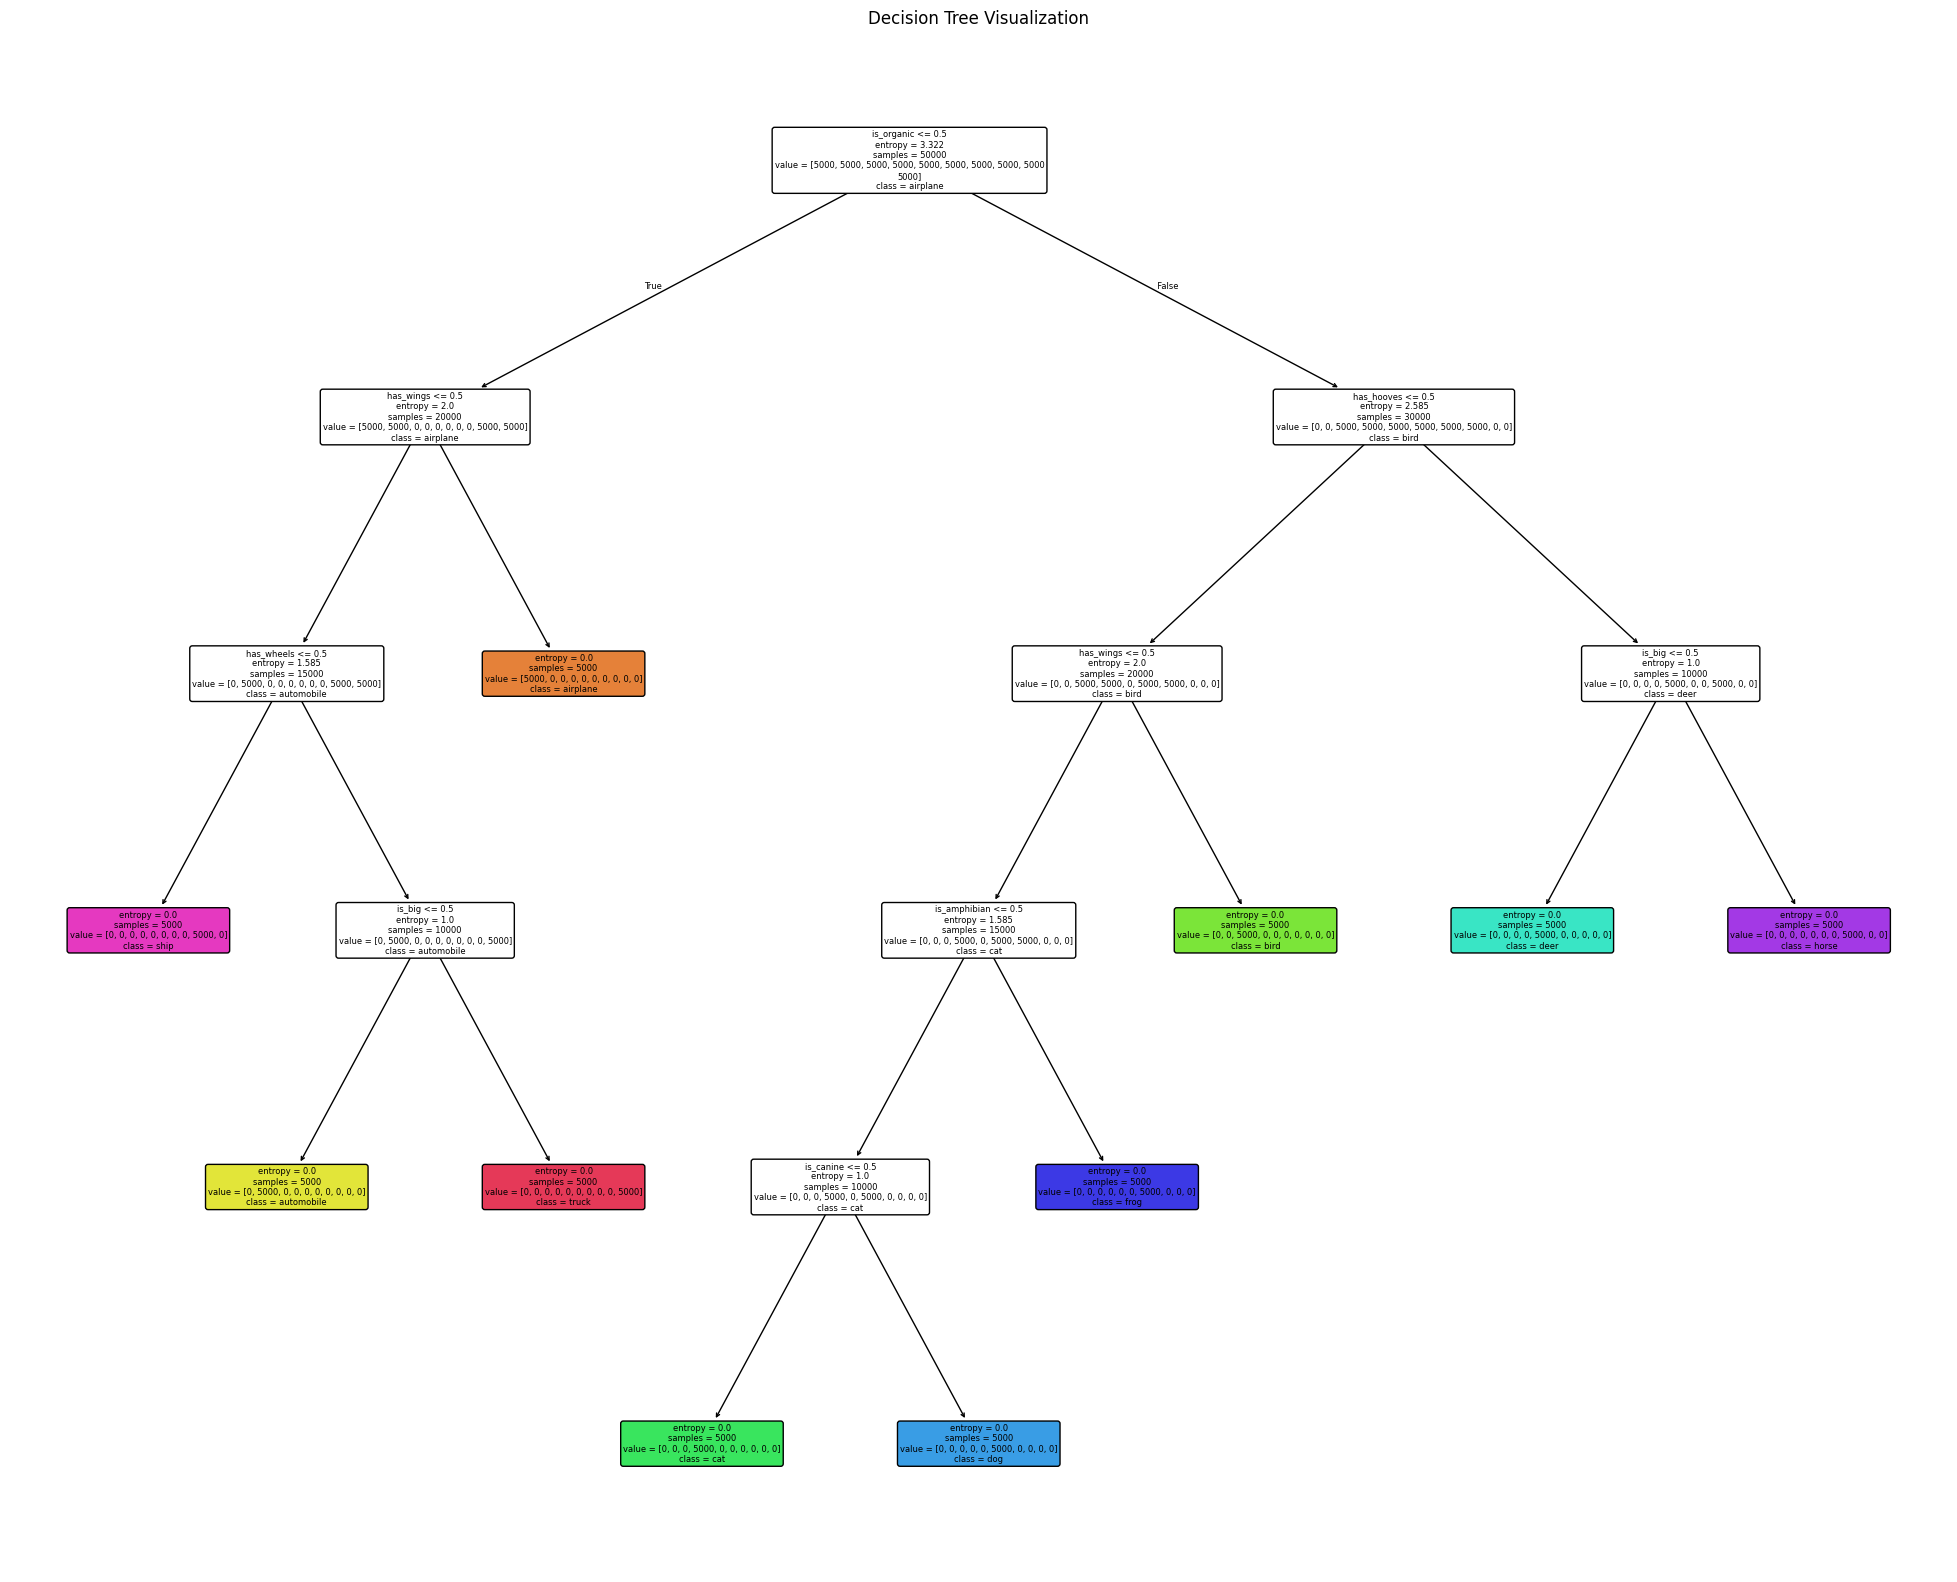

In [18]:
plt.figure(figsize=(25, 20))
plot_tree(clf, feature_names=all_possible_features, class_names=clf.classes_, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

## Complete Neuro-Symbolic Classifier

Lastly, the `NeuroSymbolicClassifier` class combines the power of neural networks with symbolic rule-based reasoning to make predictions in an explainable manner. This class combines both the induced rules, and the neural network to create the complete neuro-symbolic classifier.

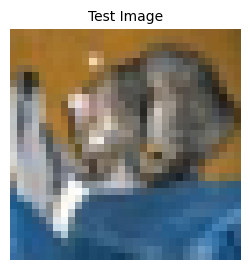

Predicted Class: cat
Applied Rule: IF  (is_organic) AND (NOT has_hooves) AND (NOT has_wings) AND (NOT is_amphibian) AND (NOT is_canine) THEN cat


In [19]:
class NeuroSymbolicClassifier:
    """
    A hybrid classifier that combines neural network predictions with symbolic rule-based reasoning.

    The model first predicts a set of feature probabilities using the neural network, then converts them into
    binary values using a threshold. Based on this feature vector, a symbolic decision tree is used to predict
    the class. If a matching rule is found, it is returned; otherwise, a default message is returned.

    Parameters:
    neural_model (nn.Module): A trained neural network model for predicting feature probabilities.
    rules (list): A list of symbolic rules to be applied based on the predicted class.
    tree (sklearn.tree.DecisionTreeClassifier): A decision tree model used for classification based on feature vector.
    threshold (float): Threshold value for converting feature probabilities to binary values (default is 0.5).
    device (str): Device to run the model on, either "cpu" or "cuda" (default is "cpu").
    """
    def __init__(self, neural_model, rules, tree, threshold=0.5, device="cpu"):
        """
        Initializes the NeuroSymbolicClassifier.

        Parameters:
        neural_model (nn.Module): The trained neural network.
        rules (list): The set of rules to use with symbolic reasoning.
        tree (sklearn.tree.DecisionTreeClassifier): The decision tree for class prediction based on the binary feature vector.
        threshold (float): Threshold to determine the binary classification of each feature.
        device (str): The device on which the neural model is run (either "cpu" or "cuda").
        """
        neural_model.to(device)
        self.neural_model = neural_model
        self.rules = rules
        self.tree = tree
        self.threshold = threshold

    def _convert_to_binary(self, feature_probs):
        """
        Converts predicted feature probabilities to binary values based on a threshold.

        Parameters:
        feature_probs (list): The list of predicted feature probabilities from the neural network.

        Returns:
        tuple: A tuple of binary values (0 or 1) based on the threshold.
        """
        return tuple(int(val >= self.threshold) for val in feature_probs)

    def _find_matching_rule(self, predicted_class):
        """
        Searches for a matching symbolic rule corresponding to the predicted class.

        Parameters:
        predicted_class (str): The predicted class from the decision tree.

        Returns:
        str: The matching rule, or "NO MATCHING RULE" if no rule is found.
        """
        for rule in self.rules:
            if predicted_class in rule:
                return rule
        return "NO MATCHING RULE"

    def predict(self, image):
        """
        Makes a prediction using the neural model, decision tree, and symbolic rules.

        Parameters:
        image (ndarray or tensor): The input image for which a prediction is made.

        Returns:
        tuple: A tuple containing the predicted class and the applied rule (if any).
        """
        image = torch.tensor(image)
        image.to(device)
        self.neural_model.eval()
        with torch.no_grad():

            feature_probs = self.neural_model(image).squeeze().tolist()
        feature_vector = np.array(self._convert_to_binary(feature_probs), dtype=np.int8)
        predicted_class = str(self.tree.predict([feature_vector])[0])
        rule = self._find_matching_rule(predicted_class)
        return predicted_class, rule

hybrid_classifier = NeuroSymbolicClassifier(model, rules, clf)
for test_image, target_class in feature_test_dataset:
    test_image = np.expand_dims(test_image[0], axis=0)
    predicted_class, applied_rule = hybrid_classifier.predict(test_image)
    test_image = test_image.squeeze()
    img = test_image.transpose((1, 2, 0))
    img = img * 0.5 + 0.5
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Test Image", fontsize=10)
    plt.show()
    break

print(f"Predicted Class: {predicted_class}")
print(f"Applied Rule: {applied_rule}")

In [20]:
with open("neuro_symbolic_classifier.pkl", "wb") as f:
    pickle.dump(hybrid_classifier, f)

print("Classifier instance saved successfully!")

Classifier instance saved successfully!
